## Project 1: American Sign Language Understanding
A project for the course of Autonomous Learning at the University of Aveiro, 2022/2023. This project was developed by Diogo Monteiro (NMec 97606) and Isabel Rosário (NMec 93343). This approach attemps to build a neural network that understands American sign language.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Load Data

Number of images in dataset: 27455
Shape of each image: (28, 28)


Text(0.5, 1.0, 'First image of the dataset')

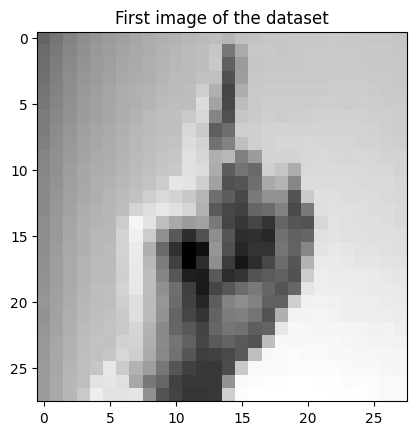

In [26]:
data = pd.read_csv('data/sign_mnist_train.csv') #, header=0)

# get number of images in the dataset (should be 27,455)
num_images = data.shape[0]
print('Number of images in dataset:', num_images)

# single out and analyse first image
first_image = data.iloc[0, 1:].values # get first image of the dataset
first_image = first_image.reshape(28, 28).astype('uint8') # reshape it to a 28x28 matrix
print('Shape of each image:', first_image.shape)

# show first image
plt.imshow(first_image, cmap='gray')
plt.title('First image of the dataset')

In [27]:
# normalize pixel information (0-255 to 0-1)
data.iloc[:, 1:] = data.iloc[:, 1:] / 255
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

### Neural network code

In [42]:
class Layer:

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backwards(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) # dL/dW = dL/dY * dY/dW
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation:

    def forward_ReLU(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backwards_ReLU(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def forward_Softmax(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backwards_Softmax(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss: # categorical cross-entropy
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class LossActivation: # combined softmax activation and cross-entropy loss for faster backward step
    def __init__(self):
        self.activation = Activation()
        self.loss = Loss()

    def forward(self, inputs, y_true):
        self.activation.forward_Softmax(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

class Optimizer: # stochastic gradient descent
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

### Testing

In [43]:
num_features = X.shape[1]
size_layer1 = 100
size_layer2 = 26

activation = Activation()
layer1 = Layer(num_features, size_layer1)
layer2 = Layer(size_layer1, size_layer2)
loss_activation = LossActivation()
optimizer = Optimizer(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
    layer1.forward(X)
    activation.forward_ReLU(layer1.output)

    layer2.forward(layer1.output)
    loss = loss_activation.forward(layer2.output, y)

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}')
    
    # backward pass
    loss_activation.backward(loss_activation.output, y)
    layer2.backwards(loss_activation.dinputs)
    activation.backwards_ReLU(layer2.dinputs)
    layer1.backwards(layer2.dinputs)

    # update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update_params()

# layer1.forward(X)
# activation.forward_ReLU(layer1.output)
# layer2.forward(layer1.output)

# loss = loss_activation.forward(layer2.output, y)
# # print(loss_activation.output[:5])
# print('Loss:', loss)

# predictions = np.argmax(loss_activation.output, axis=1)
# if len(y.shape) == 2:
#     y = np.argmax(y, axis=1)
# accuracy = np.mean(predictions == y)

# print('Accuracy:', accuracy)

# # backpropagation
# loss_activation.backward(loss_activation.output, y)
# layer2.backwards(loss_activation.dinputs)
# activation.backwards_ReLU(layer2.dinputs)
# layer1.backwards(layer2.dinputs)

# # print(layer1.dweights)
# # print(layer1.dbiases)
# # print(layer2.dweights)
# # print(layer2.dbiases)



epoch: 0, acc: 0.038, loss: 3.257, lr: 0.05
epoch: 100, acc: 0.052, loss: 3.159, lr: 0.04999752512250644
epoch: 200, acc: 0.145, loss: 3.066, lr: 0.04999502549496326
epoch: 300, acc: 0.223, loss: 2.803, lr: 0.049992526117345455
epoch: 400, acc: 0.303, loss: 2.488, lr: 0.04999002698961558
epoch: 500, acc: 0.358, loss: 2.214, lr: 0.049987528111736124
epoch: 600, acc: 0.425, loss: 2.002, lr: 0.049985029483669646
epoch: 700, acc: 0.479, loss: 1.832, lr: 0.049982531105378675
epoch: 800, acc: 0.523, loss: 1.688, lr: 0.04998003297682575
epoch: 900, acc: 0.551, loss: 1.571, lr: 0.049977535097973466
epoch: 1000, acc: 0.568, loss: 1.490, lr: 0.049975037468784345
epoch: 1100, acc: 0.591, loss: 1.399, lr: 0.049972540089220974
epoch: 1200, acc: 0.613, loss: 1.316, lr: 0.04997004295924593
epoch: 1300, acc: 0.628, loss: 1.248, lr: 0.04996754607882181
epoch: 1400, acc: 0.643, loss: 1.189, lr: 0.049965049447911185
epoch: 1500, acc: 0.652, loss: 1.161, lr: 0.04996255306647668
epoch: 1600, acc: 0.671, lo